In [239]:
#package
using Distributions
using Random
using LinearAlgebra
using Plots
using StatsBase
using LaTeXStrings
using DataFrames
using CSV
using Base.Threads
using HDF5
gr()

Plots.GRBackend()

In [330]:
c = h5open("/Users/nishimura/home/lab/exmc/result/int/spc8_chi5_B40.h5", "r") do file
    read(file, "B40")
end

1000×72 Matrix{Float64}:
  0.735415    0.635544     0.871961   …  0.115748  0.122977  0.123532
  0.85028     0.49122      0.643647      0.115748  0.122977  0.123532
  0.599191    0.334519    -0.38565       0.115184  0.123532  0.120398
  0.689558   -0.00613678  -0.33894       0.114259  0.123532  0.127798
 -0.170716   -0.0930039    0.0181894     0.113017  0.114865  0.119067
 -0.364647    0.181257     0.143002   …  0.113017  0.115006  0.10886
 -0.0875905   0.11533      0.148183      0.121506  0.1183    0.124285
 -0.286958    0.0971059    0.21915       0.121942  0.120553  0.114347
  0.0768746   0.160681     0.620516      0.116298  0.130415  0.119228
  0.422198    0.0955584    0.928893      0.116298  0.130415  0.115397
  0.443493    0.928893     0.224818   …  0.130415  0.129609  0.131861
  0.456657    0.541569     0.217408      0.121766  0.127815  0.126906
  0.525607    0.24004      0.868649      0.11423   0.126906  0.113618
  ⋮                                   ⋱            ⋮         
 -0.

In [331]:
ac = h5open("/Users/nishimura/home/lab/exmc/result/int/spc8_chi5_ac_ex.h5", "r") do file
    read(file, "ac")
end

ex = h5open("/Users/nishimura/home/lab/exmc/result/int/spc8_chi5_ac_ex.h5", "r") do file
    read(file, "ex")
end

72-element Vector{Float64}:
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 1.0
 ⋮
 0.888
 0.91
 0.884
 0.844
 0.818
 0.794
 0.834
 0.788
 0.858
 0.874
 0.908
 0.0

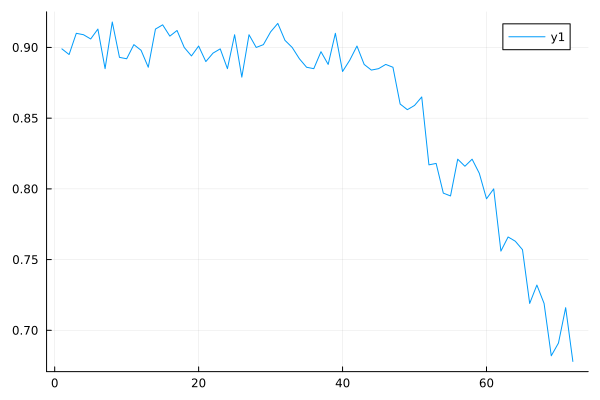

In [332]:
plot(ac)

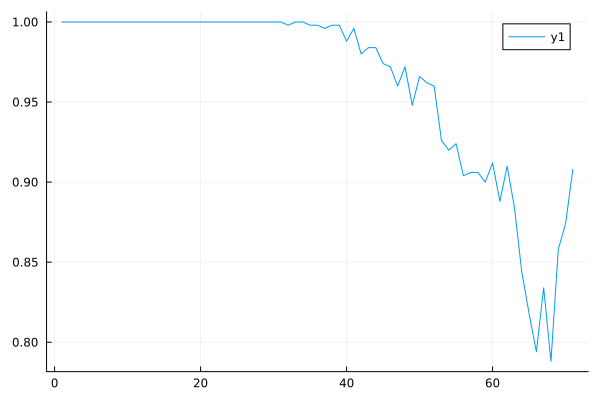

In [333]:
plot(ex[1:end-1])

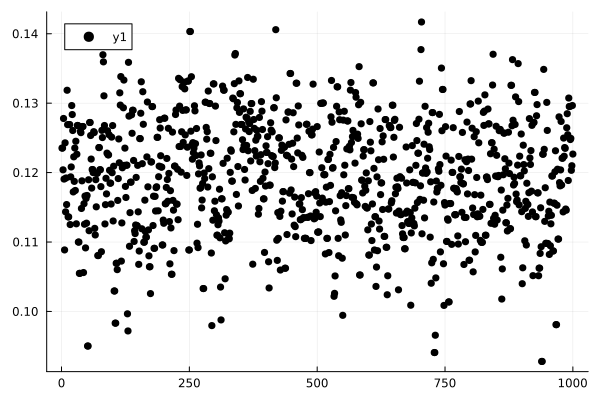

In [334]:
plot(
    c[:,end],
    st = :scatter,
    color = :black,
)

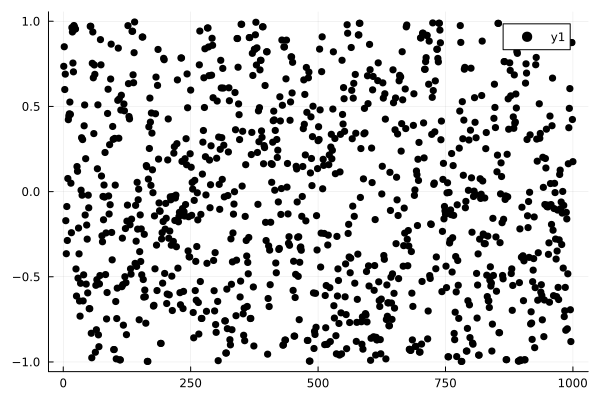

In [335]:
plot(
    c[:,1],
    st = :scatter,
    color = :black,
)

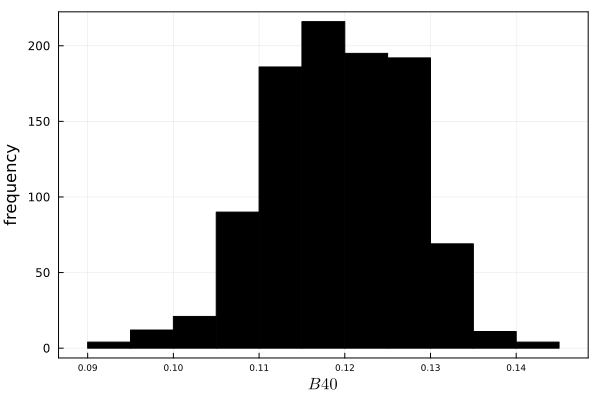

In [336]:
plot(
    c[:,end],
    st = :histogram,
    color = :black,
    label = "",
    framestyle = :box,
    xlabel = L"B40",
    ylabel = "frequency",
    xtickfont = font(6),
)

In [337]:
savefig("/Users/nishimura/home/lab/exmc/posterior/int/spc8_chi5.pdf")

"/Users/nishimura/home/lab/exmc/posterior/int/spc8_chi5.pdf"

In [342]:
# 本データ読み込み
function read_file_spc(file_path)
    file = h5open(file_path, "r")
    data = read(file, "spc")
    return data
end

# 本データ読み込み
function read_file_chi(file_path)
    file = h5open(file_path, "r")
    data = read(file, "chi_inv")
    return data
end

read_file_chi (generic function with 1 method)

In [343]:
#データ数
function data_num()
    n = 350
    return n
end
n_spc = data_num()
n_chi = data_num()

#各種結晶場パラメータ
function ini()
    # Hund's Rule Ground J-Multiplet Ce3+ n4f=1
    n4f = 1.0
    L = 3.0
    S = 0.5
    J = L - S
    g = 1.0 + (J * (J + 1.0) + S * (S + 1.0) - L * (L + 1.0)) / (2.0 * J * (J + 1.0))
    Jz = [2.5, 1.5, 0.5, -0.5, -1.5, -2.5]
    return J, g, Jz
end

#温度配列
function temp()
    Temp_table = collect(0.2:0.2:70) # length 350
    return Temp_table
end

#結晶場行列
function Onn_make(B40)
    # O40
    O40_vec_x = [60.0, -180.0, 120.0, 120.0, -180.0, 60.0]
    O40_vec = O40_vec_x * B40
    O40 = diagm(0 => O40_vec)
    Onn = O40
    # O44
    B44 = 5 * B40
    O44_value = sqrt(120.0 * 24.0) * B44 / 2.0
    Onn[5,1] = O44_value
    Onn[6,2] = O44_value
    Onn[1,5] = O44_value
    Onn[2,6] = O44_value
    return Onn
end

function spc(Onn)
    #パラメータ読み込み
    _, g, _ = ini()

    # 非対角要素
    Hmag_vec_1 = sqrt.([5,8,9,8,5]) * (1 + 1*im) * 5 * g * 0.67171 / 2
    Hmag_1 = diagm(1 => Hmag_vec_1)
    Hmag_2 = diagm(-1 => conj.(Hmag_vec_1))
    Hmag = Hmag_1 + Hmag_2

    #結晶場＋磁場ハミルトニアンの行列要素
    H = Onn + Hmag

    eigval, eigvec = eigen(H)

    Temp_table_spc = temp()
    SpcHeat_Temp = zeros(length(Temp_table_spc))
    
    @inbounds for (i, Temp) in enumerate(Temp_table_spc)
        eigval_2 = - eigval / Temp
        eigval_2_max = maximum(eigval_2)
        eigval_ratio = eigval_2 .- eigval_2_max
        exp_eigval = exp.(eigval_ratio)

        Z0 = sum(exp_eigval)
        Z1 = sum(eigval_2 .* exp_eigval)
        Z2 = sum(eigval_2.^2 .* exp_eigval)
        
        SpcHeat=(- (Z1/Z0)^2 + (Z2/Z0) )*8.31441
        SpcHeat_Temp[i] = SpcHeat
    end
    return SpcHeat_Temp
end

#磁化率生成関数
function chi(Onn)
    # 温度定義
    Temp_table_chi = temp()

    _, g, Jz = ini()
    magfield = 0.01
    #magdir = [0,0,1]
    #nor_magdir = [0,0,1]
    
    # 対角要素
    Hmag_vec_0 = Jz * magfield * g * 0.67171
    Hmag = diagm(0 => Hmag_vec_0)
    
    # 非対角要素はmagdir[x,y]が0なので0
    
    # 結晶場＋磁場ハミルトニアンの行列要素
    H = Onn + Hmag
    
    eigval, eigvec = eigen(H)

    Temp_table_chi = temp()
    chi_inv_Temp = zeros(n_chi)
    
    @inbounds for (i, Temp) in enumerate(Temp_table_chi)
        eigval_2 = - eigval / Temp
        eigval_2_max = maximum(eigval_2)
        eigval_ratio = eigval_2 .- eigval_2_max
        exp_eigval = exp.(eigval_ratio)
        sumexp = sum(exp_eigval)

        mag_z = zeros(6)
        @simd for j in 1:6
            eigvec_check = eigvec[:,j]
            mag_z[j] = eigvec_check' * (eigvec_check .* Jz) * exp_eigval[j] / sumexp
        end

        Jmag_z = sum(mag_z) * g * (-1)
        Jmag = Jmag_z

        chi = Jmag / magfield * 0.5585
        chi_inv = 1.0 / chi
        chi_inv_Temp[i] = chi_inv
    end
    return chi_inv_Temp
end


function error_spc(B40, SpcHeat_Temp_noise)
    error_value = sum((SpcHeat_Temp_noise - spc(Onn_make(B40))).^2)/(2*n_spc)
    return error_value
end

function error_spc_list(para_list, SpcHeat_Temp_noise)
    error_list = zeros(size(para_list)[1],size(para_list)[2])
    @threads for i in 1:size(para_list)[1]
        for j in 1:size(para_list)[2]
            error_list[i,j] = error_spc(para_list[i,j], SpcHeat_Temp_noise)
        end
    end
    return error_list
end


#誤差関数
function error_chi(B40,chi_inv_Temp_noise)
    error_value = sum((chi_inv_Temp_noise - chi(Onn_make(B40))).^2)/(2*n_chi)
    return error_value
end

function error_chi_list(para_list, chi_inv_Temp_noise)
    error_list = zeros(size(para_list)[1],size(para_list)[2])
    @threads for i in 1:size(para_list)[1]
        for j in 1:size(para_list)[2]
            error_list[i,j] = error_chi(para_list[i,j], chi_inv_Temp_noise)
        end
    end
    return error_list
end



error_chi_list (generic function with 1 method)

In [344]:
function make_beta(gamma,L)
    #最初は等差で決定
    beta_list = gamma.^( (2:1:L) .- (L) )
    beta_list = pushfirst!(beta_list, 0.0)
    return beta_list
end

make_beta (generic function with 1 method)

In [345]:
function find_free_energy_int(error_spc, error_chi, b_spc, b_chi, gamma, L)
    # 温度リスト
    beta = make_beta(gamma, L)
    #温度差
    beta_dif = beta[2:end] - beta[1:end-1]
    
    #温度差をかける
    for replica in 1:L-1
        error_spc[:,replica] *= beta_dif[replica]
        error_chi[:,replica] *= beta_dif[replica]
    end
    
    #n,noiseをかける
    error_spc *= - n_spc * b_spc
    error_chi *= - n_chi * b_chi
    error = error_spc .+ error_chi

    #最大値取得
    error_max = zeros(L-1)
    for replica in 1:L-1
        error_max[replica] = maximum(error[:,replica])
    end
    
    #最大値で引いたエネルギー関数
    error_dif = copy(error)
    for replica in 1:L-1
        error_dif[:,replica] = error[:,replica] .- error_max[replica]
    end
    
    #期待値計算
    log_exp_sum = zeros(L-1)
    for replica in 1:L-1
        log_exp_sum[replica] = log(sum(exp.(error_dif)[:,replica]))
    end
    
    #各レプリカでの自由エネルギー期待値
    free_energy_for_replica = -(- log(size(error)[1]) .+  error_max .+ log_exp_sum)
    
    #最終的な自由エネルギー(足し算)
    free_energy = sum(free_energy_for_replica) - n_spc/2*(log(b_spc)-log(2*pi)) - n_chi/2*(log(b_chi)-log(2*pi))
    
    return free_energy
end

find_free_energy_int (generic function with 2 methods)

In [347]:
function main(para, data_path_spc, data_path_chi, save_path)
    #para = read_para(para_path)
    SpcHeat_Temp_noise = read_file_spc(data_path_spc)
    b_spc = 10^(-2)
    error_list_spc = error_spc_list(para, SpcHeat_Temp_noise)

    chi_inv_Temp_noise = read_file_chi(data_path_chi)
    b_chi = 10^(-2)
    error_list_chi = error_chi_list(para, chi_inv_Temp_noise)

    #レプリカ数
    L = 72
    #逆温度間隔決定
    gamma = 1.4
    # 自由エネルギー
    free_energy = find_free_energy_int(error_list_spc, error_list_chi, b_spc, b_chi, gamma, L)
    

    # データフレームに書き出し
    #df_error = DataFrame(error_list, :auto)
    #df_error |> CSV.write(save_path * "error.csv",writeheader=true)

    #free_path = save_path * "free.h5"
    #=
    h5open(free_path, "w") do file
        write(file,"free",free_energy)
    end
    =#

    print("free_energy=", free_energy)
end

main (generic function with 1 method)

In [348]:
data_path_spc = "/Users/nishimura/home/lab/data_make/data/spc/spc_8.h5"
data_path_chi = "/Users/nishimura/home/lab/data_make/data/chi_inv/chi_inv_5.h5"

#save_path = "/Users/nishimura/home/lab/exmc/free_energy_check/int/spc5_chi3_"
savepath = ""

main(c, data_path_spc, data_path_chi, save_path)

free_energy=2606.2762024005588

In [ ]:
# now 8